_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 4

In this notebook you will work with preprocessed 2 photon calcium recordings, that have already been converted into spike counts for a population of cells from the Macaque V1. During the experiment the animal has been presented with several drifting grating stimuli, in response to which the neural activity was recorded. In this exercise sheet we will study how you can visualize the activity of multiple neural spike trains and assess whether a neuron is selective to a specific stimulus type.

Download the data files ```nds_cl_4_*.csv``` from ILIAS and save it in the subfolder ```../data/```. We recommend you to use a subset of the data for testing and debugging, ideally focus on a single cell (e.g. cell number x). The spike times and stimulus conditions are read in as pandas data frames. You can solve the exercise by making heavy use of that, allowing for many quite compact computations. See [documentation](http://pandas.pydata.org/pandas-docs/stable/index.html) and several good [tutorials](https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python#gs.L37i87A) on how to do this. Of course, converting the data into classical numpy arrays is also valid.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.optimize as opt

from scipy import signal as signal
from typing import Tuple

import itertools
import logging

%matplotlib inline

#%load_ext jupyter_black

#%load_ext watermark
#%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

In [38]:
#%%
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(message)s",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.info("Starting the script...")


# --- Add these lines to suppress Matplotlib's DEBUG messages ---
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING) # Or logging.INFO, logging.ERROR
# You can also target specific noisy submodules if needed:
# logging.getLogger('matplotlib.font_manager').setLevel(logging.WARNING)
# logging.getLogger('matplotlib.pyplot').setLevel(logging.WARNING)
# --- End of added lines ---

2025-05-18 11:37:57,458 - INFO - Starting the script...


In [39]:
plt.style.use("../matplotlib_style.txt")

In [41]:
sns.set_theme(
    style="whitegrid",
    palette="deep",
    font_scale=1.5
)

## Load data

In [5]:
spikes = pd.read_csv("../data/nds_cl_4_spiketimes.csv")  # neuron id, spike time
stims = pd.read_csv("../data/nds_cl_4_stimulus.csv")  # stimulus onset in ms, direction

stimDur = 2000.0  # in ms
nTrials = 11  # number of trials per condition
nDirs = 16  # number of conditions
deltaDir = 22.5  # difference between conditions

stims["StimOffset"] = stims["StimOnset"] + stimDur

We require some more information about the spikes for the plots and analyses we intend to make later. With a solution based on dataframes, it is natural to compute this information here and add it as additional columns to the `spikes` dataframe by combining it with the `stims` dataframe. We later need to know which condition (`Dir`) and trial (`Trial`) a spike was recorded in, the relative spike times compared to stimulus onset of the stimulus it was recorded in (`relTime`) and whether a spike was during the stimulation period (`stimPeriod`). But there are many options how to solve this exercise and you are free to choose any of them.

In [6]:
# you may add computations as specified above
spikes["Dir"] = np.nan
spikes["relTime"] = np.nan
spikes["Trial"] = np.nan
spikes["stimPeriod"] = np.nan

dirs = np.unique(stims["Dir"])
trialcounter = np.zeros_like(dirs)

for i, row in stims.iterrows():
    trialcounter[dirs == row["Dir"]] += 1

    i0 = spikes["SpikeTimes"] > row["StimOnset"]
    i1 = spikes["SpikeTimes"] < row["StimOffset"]

    select = i0.values & i1.values

    spikes.loc[select, "Dir"] = row["Dir"]
    spikes.loc[select, "Trial"] = trialcounter[dirs == row["Dir"]][0]
    spikes.loc[select, "relTime"] = spikes.loc[select, "SpikeTimes"] - row["StimOnset"]
    spikes.loc[select, "stimPeriod"] = True

spikes = spikes.dropna()

/var/folders/_q/9l1zk1853mv45phss2fsffd00000gn/T/ipykernel_30883/4012369867.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  spikes.loc[select, "stimPeriod"] = True


In [7]:
spikes.head()

,Neuron,SpikeTimes,Dir,relTime,Trial,stimPeriod
514,1,15739.000000,270.0,169.000000,1.0,True
515,1,15776.566667,270.0,206.566667,1.0,True
516,1,15808.466667,270.0,238.466667,1.0,True
517,1,15821.900000,270.0,251.900000,1.0,True
518,1,15842.966667,270.0,272.966667,1.0,True


## Task 1: Plot spike rasters

In a raster plot, each spike is shown by a small tick at the time it occurs relative to stimulus onset. Implement a function `plotRaster()` that plots the spikes of one cell as one trial per row, sorted by conditions (similar to what you saw in the lecture). Why are there no spikes in some conditions and many in others?

If you opt for a solution without a dataframe, you need to change the interface of the function.

*Grading: 3 pts*


In [ ]:
def plotRaster(spikes: pd.DataFrame, neuron: int):
    """plot spike rasters for a single neuron sorted by condition

    Parameters
    ----------

    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod

    neuron: int
        Neuron ID


    Note
    ----

    this function does not return anything, it just creates a plot!
    """

    # -------------------------------------------------
    # Write a raster plot function for the data (2 pts)
    # -------------------------------------------------
    pass

Find examples of 
1. a direction selective neuron
2. an orientation selective neuron 
3. neither

and explain your choices.

In [ ]:
# ---------------------------------
# Find and explain examples? (1 pt)
# ---------------------------------

## Task 2: Plot spike density functions

Compute an estimate of the spike rate against time relative to stimulus onset. There are two ways:
* Discretize time: Decide on a bin size, count the spikes in each bin and average across trials. 
* Directly estimate the probability of spiking using a density estimator with specified kernel width. 

For full points, the optimal kernel- or bin-width needs to be computed.

Implement one of them in the function `plotPSTH()`. If you dont use a dataframe you may need to change the interface of the function.


*Grading: 4 pts*


In [ ]:
def plotPSTH(spikes: pd.DataFrame, neuron: int):
    """Plot PSTH for a single neuron sorted by condition

    Parameters
    ----------

    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod

    neuron: int
        Neuron ID


    Note
    ----

    this function does not return anything, it just creates a plot!
    """

    # -------------------------------------------------
    # Implement one of the spike rate estimates (3 pts)
    # -------------------------------------------------

    for row, dir in enumerate(dirs):
        # ---------------------------------------------
        # Plot the obtained spike rate estimates (1 pt)
        # ---------------------------------------------
        continue

Plot the same 3 examples you selected in Task 1

## Task 3: Fit and plot tuning functions

The goal is to visualize the activity of each neuron as a function of stimulus direction. First, compute the spike counts of each neuron for each direction of motion and trial.  The result should be a matrix `x`, where $x_{jk}$ represents the spike count of the $j$-th response to the $k$-th direction of motion (i.e. each column contains the spike counts for all trials with one direction of motion).	If you used dataframes above, the `groupby()` function allows to implement this very compactly. Make sure you don't loose trials with zero spikes though. Again, other implementations are completely fine.

Fit the tuning curve, i.e. the average spike count per direction, using a von Mises model. To capture the non-linearity and direction selectivity of the neurons, we will fit a modified von Mises function:

$$ f(\theta) = \exp(\alpha + \kappa (\cos (2*(\theta-\phi))-1) + \nu (\cos (\theta-\phi)-1))$$

Here, $\theta$ is the stimulus direction. Implement the von Mises function in `vonMises()` and plot it to understand how to interpret its parameters $\phi$, $\kappa$, $\nu$, $\alpha$. Perform a non-linear least squares fit using a package/function of your choice. Implement the fitting in `tuningCurve()`. 

Plot the average number of spikes per direction, the spike counts from individual trials as well as your optimal fit.

Select two cells that show nice tuning to test your code.

*Grading: 5 pts*

In [8]:
def vonMises(θ: np.ndarray, α: float, κ: float, ν: float, ϕ: float) -> np.ndarray:
    """Evaluate the parametric von Mises tuning curve with parameters p at locations theta.

    Parameters
    ----------

    θ: np.array, shape=(N, )
        Locations. The input unit is degree.

    α, κ, ν, ϕ : float
        Function parameters

    Return
    ------
    f: np.array, shape=(N, )
        Tuning curve.
    """

    # -----------------------------------
    # Implement the Mises model (0.5 pts)
    # -----------------------------------

    pass

In [9]:
def vonMises(θ: np.ndarray, α: float, κ: float, ν: float, ϕ: float) -> np.ndarray:
    """Evaluate the parametric von Mises tuning curve 
        with parameters p at locations theta.

    Parameters
    ----------

    θ: np.array, shape=(N, )
        Locations. The input unit is degree.

    α, κ, ν, ϕ : float
        Function parameters

    Return
    ------
    f: np.array, shape=(N, )
        Tuning curve.
    """

    # -----------------------------------
    # Implement the Mises model (0.5 pts)
    # -----------------------------------
    return np.exp(α + κ * (np.cos(2 * (θ - ϕ)) - 1) \
        + ν * (np.cos(θ - ϕ) - 1))

Plot the von Mises function while varying the parameters systematically.

/var/folders/_q/9l1zk1853mv45phss2fsffd00000gn/T/ipykernel_30883/38370202.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


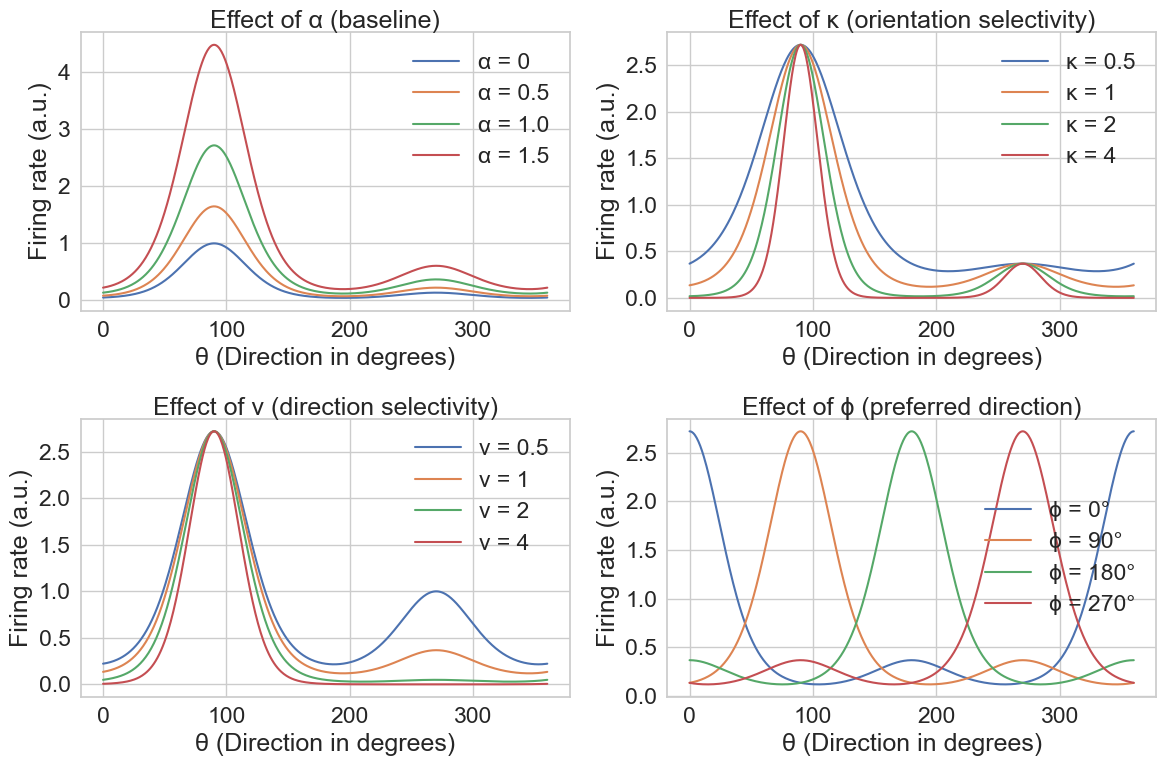

In [51]:
# ------------------------------------------------------------------------------
# plot von Mises curves with varying parameters and explain what they do (2 pts)
# ------------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt


def plot_vonMises_param_effects():
    θ = np.linspace(0, 360, 500)

    # Baseline parameters
    α = 1.0
    κ = 1.0
    ν = 1.0
    ϕ = 90.0
    
    theta_rad = np.deg2rad(θ)  # convert degrees to radians
    phi_rad = np.deg2rad(ϕ)  # convert degrees to radians

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.ravel()

    # Vary α (baseline)
    for a in [0, 0.5, 1.0, 1.5]:
        f = vonMises(theta_rad, α=a, κ=κ, ν=ν, ϕ=phi_rad)
        axs[0].plot(θ, f, label=f"α = {a}")
    axs[0].set_title("Effect of α (baseline)")
    axs[0].legend()

    # Vary κ (orientation tuning sharpness)
    for k in [0.5, 1, 2, 4]:
        f = vonMises(theta_rad, α=α, κ=k, ν=ν, ϕ=phi_rad)
        axs[1].plot(θ, f, label=f"κ = {k}")
    axs[1].set_title("Effect of κ (orientation selectivity)")
    axs[1].legend()

    # Vary ν (direction tuning sharpness)
    for n in [0.5, 1, 2, 4]:
        f = vonMises(theta_rad, α=α, κ=κ, ν=n, ϕ=phi_rad)
        axs[2].plot(θ, f, label=f"ν = {n}")
    axs[2].set_title("Effect of ν (direction selectivity)")
    axs[2].legend()

    # Vary ϕ (preferred direction)
    for phi in [0, 90, 180, 270]:
        ϕ_rad = np.deg2rad(phi)
        f = vonMises(theta_rad, α=α, κ=κ, ν=ν, ϕ=ϕ_rad)
        axs[3].plot(θ, f, label=f"ϕ = {phi}°")
    axs[3].set_title("Effect of ϕ (preferred direction)")
    axs[3].legend()

    for ax in axs:
        ax.set_xlabel("θ (Direction in degrees)")
        ax.set_ylabel("Firing rate (a.u.)")
        ax.grid(True)

    plt.tight_layout()
    plt.show()


plot_vonMises_param_effects()

In [10]:
def compute_spike_count_matrix(counts: np.ndarray, dirs: np.ndarray) -> np.ndarray:
    """Compute the spike count matrix from the counts and dirs.

    Parameters
    ----------
    counts: np.ndarray
        The spike counts for each trial.

    dirs: np.ndarray
        The stimulus directions for each trial.

    Returns
    -------
    spike_count_matrix: np.ndarray
        The computed spike count matrix.
    """
    unique_stim_directions_deg = np.unique(dirs)  # Shape: (nDirs,)
    num_unique_directions = len(unique_stim_directions_deg)
    logger.debug(f"Unique stimulus directions: {unique_stim_directions_deg}")
    logger.debug(f"Number of unique stimulus directions: {num_unique_directions}")
 
    # Get the unique stimulus directions, sorted. These will be the columns of our matrix.
    unique_stim_directions_deg = np.unique(dirs)  # Shape: (nDirs,)
    num_unique_directions = len(unique_stim_directions_deg)
    # Initialize the spike count matrix `x` with shape (nTrials, nDirs)
    # x_jk: j-th trial (row), k-th direction (column)
    spike_count_matrix_x = np.zeros((nTrials, num_unique_directions))    
    # Populate the matrix
    for k_idx, direction_value in enumerate(unique_stim_directions_deg):
        # Extract all spike counts from the 1D 'counts' array that correspond to the current 'direction_value'
        counts_for_this_direction = counts[dirs == direction_value]
        # The get_data function should ensure that 'counts_for_this_direction'
        # has exactly 'nTrials' elements.
        if len(counts_for_this_direction) == nTrials:
            spike_count_matrix_x[:, k_idx] = counts_for_this_direction
        else:
            # This part handles unexpected lengths, though get_data should prevent this.
            # If fewer than nTrials, pad with zeros (already done by get_data, but good for robustness).
            # If more than nTrials (unlikely), take the first nTrials.
            actual_trials_found = len(counts_for_this_direction)
            if actual_trials_found >= nTrials:
                spike_count_matrix_x[:, k_idx] = counts_for_this_direction[:nTrials]
            else: # actual_trials_found < nTrials
                spike_count_matrix_x[:actual_trials_found, k_idx] = counts_for_this_direction
                # The remaining (nTrials - actual_trials_found) elements will stay zero 
                # due to initialization with np.zeros.
    return spike_count_matrix_x

In [11]:
def inital_von_mises_params(mean_counts_to_fit: np.ndarray, unique_dirs_rad: np.ndarray) -> tuple:
    """Initial guess for the von Mises parameters based on mean counts.
    Parameters
    ----------
    mean_counts_to_fit: np.ndarray
        The mean counts for each direction.
    unique_dirs_rad: np.ndarray
        The unique directions in radians.
    Returns
    -------
    tuple: (alpha_guess, kappa_guess, nu_guess, phi_guess_rad)
        Initial guesses for the parameters of the von Mises function.
    """
    # Robust initial guesses:
    if not np.any(mean_counts_to_fit > 1e-9): # Handle cases where all mean counts are zero or tiny
        alpha_guess = np.log(1e-6) # A small baseline
        phi_guess_rad = 0.0        # Default preferred direction
    else:
        # For alpha, use log of mean of positive counts, or log of max if all else fails
        positive_mean_counts = mean_counts_to_fit[mean_counts_to_fit > 1e-9]
        if len(positive_mean_counts) > 0:
            alpha_guess = np.log(np.maximum(1e-6, np.mean(positive_mean_counts)))
        else: # Should be caught by the outer if, but as a fallback
            alpha_guess = np.log(np.maximum(1e-6, np.max(mean_counts_to_fit)))
        
        phi_guess_rad = unique_dirs_rad[np.argmax(mean_counts_to_fit)]

    kappa_guess = 1.0  # Initial guess for bimodal strength
    nu_guess = 1.0     # Initial guess for unimodal strength 
    return alpha_guess, kappa_guess, nu_guess, phi_guess_rad


In [ ]:
def tuningCurve(counts: np.ndarray, dirs: np.ndarray, show: bool = True) -> np.ndarray:
    """Fit a von Mises tuning curve to the spike counts in count with direction dir using a least-squares fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    show: bool, default=True
        Plot or not.


    Return
    ------
    p: np.array or list, (4,)
        parameter vector of tuning curve function
    """
    # ----------------------------------------
    # Compute the spike count matrix (0.5 pts)
    # ----------------------------------------

    # ------------------------------------------------------------
    # fit the von Mises tuning curve to the spike counts (0.5 pts)
    # -----------------------------------------------------------
    if show:
        # --------------------------------------------
        # plot the data and fitted tuning curve (1 pt)
        # --------------------------------------------
        pass

In [54]:
def plot_tuning_curve_fit(neuron_id: int, counts: np.ndarray, dirs: np.ndarray,
                          mean_counts_to_fit: np.ndarray, p_opt: np.ndarray,
                          r_squared: float = None) -> None:
    """Plot the tuning curve fit for a single neuron.
    Parameters
    ----------
    neuron_id: int
        The ID of the neuron being plotted.
    counts: np.ndarray
        The spike counts for each trial.
    dirs: np.ndarray
        The stimulus directions for each trial.
    mean_counts_to_fit: np.ndarray
        The mean counts for each direction.
    p_opt: np.ndarray
        The optimized parameters from the von Mises fit.
    r_squared: float, optional 
        The R-squared value of the fit, if available.
    """
    plt.figure(figsize=(10, 7)) # Adjusted figure size for better layout
    # 1. Plot individual trial spike counts (scatter plot)
    # Add some jitter to x-values for better visibility if many trials per direction
    unique_stim_directions_deg = np.unique(dirs) 
    unique_dir_vals_plot = np.unique(dirs)
    dir_spacing = np.min(np.diff(unique_dir_vals_plot)) if len(unique_dir_vals_plot) > 1 else 22.5 # Default spacing
    jitter_strength = dir_spacing * 0.05 # Small jitter
    
    # Create a mapping from original direction to jittered direction for consistency
    # Only apply jitter if there are multiple trials for a direction, otherwise center it.
    jittered_dirs = np.copy(dirs).astype(float)
    for ud in unique_dir_vals_plot:
        trials_for_dir_mask = (dirs == ud)
        num_trials_this_dir = np.sum(trials_for_dir_mask)
        if num_trials_this_dir > 1:
                jittered_dirs[trials_for_dir_mask] += np.random.uniform(-jitter_strength, jitter_strength, num_trials_this_dir)
    
    plt.scatter(jittered_dirs, counts, alpha=0.3, s=25, color='darkgray', label='Individual Trial Counts', zorder=1)

    # 2. Plot average spike counts per direction
    # Calculate standard error of the mean (SEM) for error bars if desired
    # sem_counts = np.std(spike_count_matrix_x, axis=0) / np.sqrt(spike_count_matrix_x.shape[0])
    # plt.errorbar(unique_stim_directions_deg, mean_counts_to_fit, yerr=sem_counts,
    #              fmt='o', color='dodgerblue', markersize=8, capsize=5,
    #              label='Mean Counts (±SEM)', zorder=2)
    # Or simpler, just plot mean points:
    plt.plot(unique_stim_directions_deg, mean_counts_to_fit, 'o', color='dodgerblue', markersize=8, 
                label='Mean Spike Count', zorder=2)


    # 3. Plot the fitted von Mises curve (if fit was successful)
    if p_opt is not None:
        theta_plot_deg = np.linspace(0, 360, 361) # Smooth range of angles in degrees
        theta_plot_rad = np.deg2rad(theta_plot_deg) # Convert to radians for vonMises function
        
        fitted_values = vonMises(theta_plot_rad, *p_opt)
            
        plt.plot(theta_plot_deg, fitted_values, '-', color='red', linewidth=2.5, 
                    label=f'Von Mises Fit (R²={r_squared:.2f})' if r_squared is not None else 'Von Mises Fit', 
                    zorder=3)
    else:
        logger.info(f"Neuron {neuron_id if neuron_id else 'Unknown'}: No fit to plot.")


    plt.xlabel("Direction of motion (degrees)")
    plt.ylabel("Spike count")
    title_parts = ["Tuning Curve"]
    if neuron_id is not None:
        title_parts.append(f"Neuron {neuron_id}")
    if p_opt is None:
        title_parts.append("(Fit Failed)")
    
    plt.title(" - ".join(title_parts))
    plt.xticks(np.arange(0, 361, 45))
    plt.xlim(-10, 370) # Give a bit of space around 0 and 360
    
    # Adjust y-limits dynamically
    min_y_val = 0
    if len(counts) > 0:
        min_y_val = min(0, np.min(counts) - 1)
        max_y_val = np.max(counts) + max(1, np.std(counts) * 0.5) # Ensure some space above max count
        if p_opt is not None: # Also consider fitted curve for ymax
            max_y_val = max(max_y_val, np.max(fitted_values) * 1.1)
        plt.ylim(bottom=min_y_val, top=max_y_val)
    else:
        plt.ylim(bottom=0, top=1) # Default if no counts

    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [55]:
def tuningCurve(counts: np.ndarray, dirs: np.ndarray, show: bool = True) -> np.ndarray:
    """Fit a von Mises tuning curve to the spike counts in count with 
    direction dir using a **least-squares fit**.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    show: bool, default=True
        Plot or not.


    Return
    ------
    p: np.array or list, (4,)
        parameter vector of tuning curve function
    """
    # ----------------------------------------
    # Compute the spike count matrix (0.5 pts)
    # ----------------------------------------
    logger.info("Fitting tuning curve...")
    logger.info(f"Counts: {counts.shape}")
    logger.info(f"Dirs: {dirs.shape}")

    spike_count_matrix_x = compute_spike_count_matrix(counts, dirs)
    
    logger.info(f"Spike count matrix shape: {spike_count_matrix_x.shape}") 
    logger.info(f"Spike count matrix: {spike_count_matrix_x}")

    # ------------------------------------------------------------
    # fit the von Mises tuning curve to the spike counts (0.5 pts)
    # ------------------------------------------------------------


    # 1. Calculate mean spike counts per direction
    mean_counts_to_fit = np.mean(spike_count_matrix_x, axis=0)
    logger.info(f"Mean counts to fit: {mean_counts_to_fit}")
    
    # 2. Get unique directions (degrees) and convert to radians
    # 'dirs' is the original 1D array of directions for all trials passed to tuningCurve
    unique_stim_directions_deg = np.unique(dirs) 
    unique_dirs_rad = np.deg2rad(unique_stim_directions_deg)
    logger.info(f"Unique directions (radians) for fitting: {unique_dirs_rad}")

    # Check if there's enough data to fit (at least as many points as parameters)
    if len(unique_dirs_rad) < 4: # vonMises has 4 parameters
        logger.warning(f"Not enough unique directions ({len(unique_dirs_rad)}) to fit the von Mises model. Need at least 4. Skipping fit.")
        p_opt = None # Indicate fit failed
    else:
        alpha_guess, kappa_guess, nu_guess, phi_guess_rad = inital_von_mises_params(mean_counts_to_fit, unique_dirs_rad)
        p0 = [alpha_guess, kappa_guess, nu_guess, phi_guess_rad]
        logger.info(f"Initial parameter guesses (p0): {p0}")
        # Bounds: alpha, kappa>=0, nu>=0, phi in [0, 2*pi]
        bounds = ([-np.inf, 0, 0, 0], [np.inf, np.inf, np.inf, 2 * np.pi])
        # Fit the von Mises function to the mean counts
        # 4. Perform the non-linear least squares fit
        try:
            p_opt, p_cov = opt.curve_fit(
                f=vonMises,          # Your vonMises function (make sure it's defined and accessible)
                xdata=unique_dirs_rad,
                ydata=mean_counts_to_fit,
                p0=p0,
                bounds=bounds,
                maxfev=5000          # Maximum number of function evaluations
            )
            logger.info(f"Optimized parameters (p_opt): {p_opt}")
        except RuntimeError:
            logger.warning("RuntimeError: Optimal parameters not found during curve_fit. Fit failed.")
            p_opt = None # Or assign np.full(4, np.nan) if you prefer NaNs for failed fits
        except ValueError as e:
            logger.warning(f"ValueError during curve_fit: {e}. Fit failed.")
            p_opt = None

 
        if show:
            # --------------------------------------------
            # plot the data and fitted tuning curve (1 pt)
            # --------------------------------------------
            plot_tuning_curve_fit(
                neuron_id=None,  # Replace with actual neuron ID if available
                counts=spike_count_matrix_x.flatten(),
                dirs=dirs,
                mean_counts_to_fit=mean_counts_to_fit,
                p_opt=p_opt,
                r_squared=None,  # Replace with actual R-squared value if available
                # r_squared=1 - (np.sum((mean_counts_to_fit - vonMises(unique_dirs_rad, *p_opt))**2) / np.sum((mean_counts_to_fit - np.mean(mean_counts_to_fit))**2))
            ) 
        return p_opt


Plot tuning curve and fit for different neurons. Good candidates to check are 28, 29 or 37. 

In [14]:
def get_data(spikes, neuron):
    spk_by_dir = (
        spikes[spikes["Neuron"] == neuron]
        .groupby(["Dir", "Trial"])["stimPeriod"]
        .sum()
        .astype(int)
        .reset_index()
    )

    dirs = spk_by_dir["Dir"].values
    counts = spk_by_dir["stimPeriod"].values

    # because we count spikes only when they are present, some zero entries in the count vector are missing
    for i, Dir in enumerate(np.unique(spikes["Dir"])):
        m = nTrials - np.sum(dirs == Dir)
        if m > 0:
            dirs = np.concatenate((dirs, np.ones(m) * Dir))
            counts = np.concatenate((counts, np.zeros(m)))

    idx = np.argsort(dirs)
    dirs_sorted = dirs[idx]  # sorted dirs
    counts_sorted = counts[idx]

    return dirs_sorted, counts_sorted

2025-05-18 12:35:47,968 - INFO - Fitting tuning curve...
2025-05-18 12:35:47,968 - INFO - Counts: (176,)
2025-05-18 12:35:47,969 - INFO - Dirs: (176,)
2025-05-18 12:35:47,971 - INFO - Spike count matrix shape: (11, 16)
2025-05-18 12:35:47,973 - INFO - Spike count matrix: [[ 0. 16. 14.  0.  0.  0.  0.  0.  0. 32. 31.  0.  0.  0.  0.  0.]
 [ 0. 10. 13.  0.  0.  0.  0.  0.  0. 44. 19.  0.  0.  0.  0.  0.]
 [ 0. 20. 14.  0.  0.  0.  0.  0.  0. 41. 42.  0.  0.  0.  0.  0.]
 [ 0. 10. 16.  0.  0.  0.  0.  0.  0. 54. 32.  0.  0.  0.  0.  0.]
 [ 0. 24. 16.  0.  0.  0.  0.  0.  0. 43. 55.  0.  0.  0.  0.  0.]
 [ 0.  9. 13.  0.  0.  0.  0.  0.  0. 52. 41.  0.  0.  0.  0.  0.]
 [ 0. 19. 15.  0.  0.  0.  0.  0.  0. 44. 30.  3.  0.  0.  0.  0.]
 [ 0. 15.  3.  0.  0.  0.  0.  0.  0. 48. 47.  1.  0.  0.  0.  0.]
 [ 0. 25. 24.  0.  0.  0.  0.  0.  3. 45. 26.  1.  0.  0.  0.  0.]
 [ 0. 11. 29.  0.  1.  0.  0.  0.  1. 37. 40.  2.  0.  0.  0.  0.]
 [ 0. 14. 17.  0.  0.  0.  0.  0.  0. 48. 39.  2.  0.  0. 

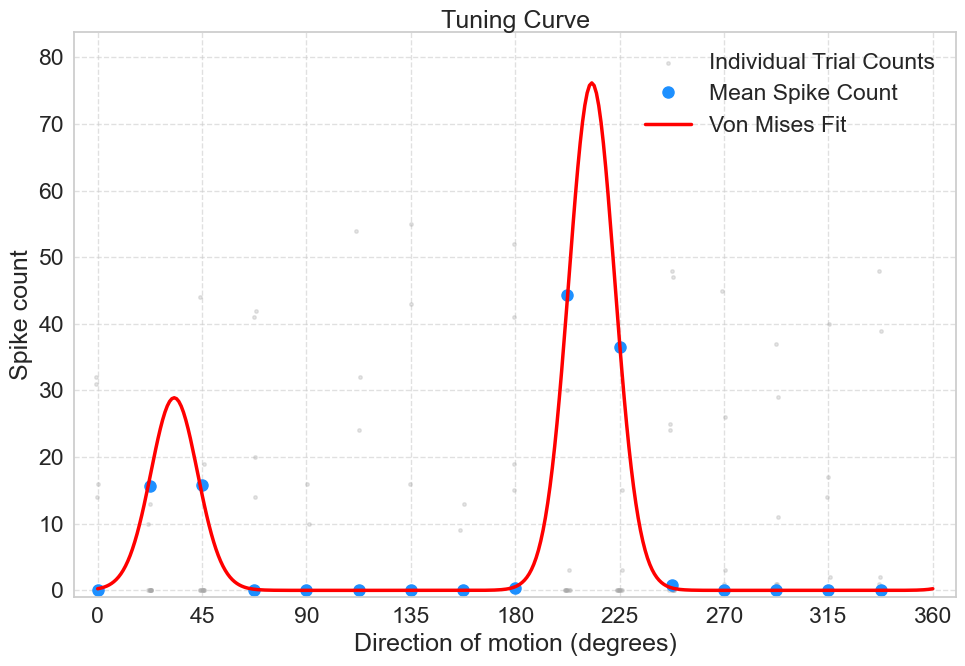

2025-05-18 12:35:48,376 - INFO - Fitting tuning curve...
2025-05-18 12:35:48,376 - INFO - Counts: (176,)
2025-05-18 12:35:48,377 - INFO - Dirs: (176,)
2025-05-18 12:35:48,379 - INFO - Spike count matrix shape: (11, 16)
2025-05-18 12:35:48,380 - INFO - Spike count matrix: [[ 5.  2.  4. 13.  2.  0.  0.  9.  0.  1. 24.  0.  2.  0.  1.  1.]
 [ 0.  0. 19. 20.  8.  3.  0.  3.  2.  0.  9.  8.  4.  0.  0.  2.]
 [ 0.  0.  9. 19. 13.  1.  0.  4.  0.  0.  6.  0. 15.  0.  0.  6.]
 [ 0.  0.  1. 16.  3.  1.  5.  2.  0.  1.  7. 11.  7.  0.  0.  6.]
 [ 0.  0. 28. 12.  3.  1. 10.  1.  0.  0.  1.  7.  6.  0.  0.  1.]
 [ 0.  0. 14. 25.  7.  4.  1.  8.  0.  0.  1.  4.  5.  0.  0.  0.]
 [ 0.  0. 15. 12.  9.  2.  1.  3.  3.  0. 11.  3.  7.  0.  0.  2.]
 [ 6.  4. 19. 27.  5.  2.  4.  5.  4.  0. 16.  6.  6.  1.  0.  0.]
 [ 3.  2. 14. 23.  5.  2.  3.  2.  4.  0. 16.  4.  5.  1.  0.  0.]
 [ 2.  1. 10. 19. 11.  2.  5.  1.  3.  8.  5.  7.  3.  0.  0.  4.]
 [ 1.  1. 26. 24.  3.  2.  4.  3.  3.  3.  6.  1. 20.  1. 

Neuron 28: dirs_sorted.shape = (176,), counts_sorted.shape = (176,)


/var/folders/_q/9l1zk1853mv45phss2fsffd00000gn/T/ipykernel_30883/990372359.py:89: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


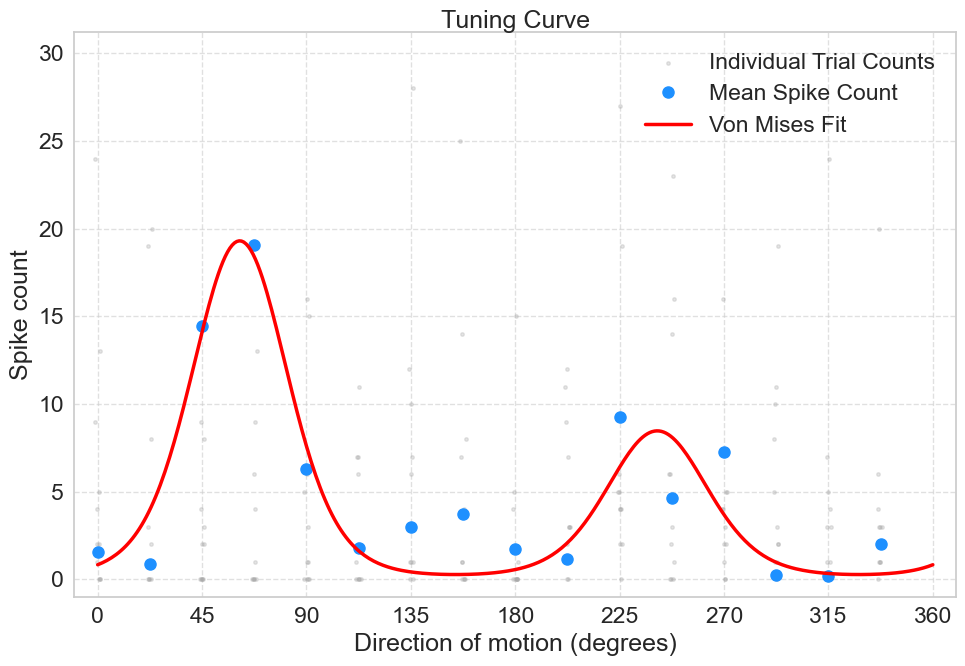

2025-05-18 12:35:48,734 - INFO - Fitting tuning curve...
2025-05-18 12:35:48,734 - INFO - Counts: (176,)
2025-05-18 12:35:48,735 - INFO - Dirs: (176,)
2025-05-18 12:35:48,737 - INFO - Spike count matrix shape: (11, 16)
2025-05-18 12:35:48,739 - INFO - Spike count matrix: [[ 10.   4.   1.  82.  66.   0.   0.  15.   5.   0.   0.   3.   6.   2.
    0.  11.]
 [ 11.   9.   0.  84.  62.   0.   0.   8.  12.   0.   0.   9.   4.   0.
    2.   5.]
 [  5.   5.   1.  82.  52.   0.   0.  15.   2.   0.   0.   2.   4.   0.
    1.  10.]
 [  8.   5.   2.  82.  43.   0.   0.   4.   7.   3.   0.  19.   2.   0.
    6.  13.]
 [ 10.   4.   5.  94.  48.   0.   1.   9.   9.   1.   0.   9.   1.   0.
    2.   9.]
 [ 11.   6.   0.  57.  47.   3.   2.   8.  10.   1.   0.   6.  13.   0.
    2.  11.]
 [  5.   3.   2. 109.  47.   2.   3.  10.   6.   5.   0.  10.   2.   0.
    3.  10.]
 [  6.   4.   3.  67.  50.   1.   1.   8.   2.   1.   0.   8.   2.   0.
    5.   5.]
 [ 12.   5.   1.  75.  46.   1.   3.   5.   7.  

Neuron 29: dirs_sorted.shape = (176,), counts_sorted.shape = (176,)


/var/folders/_q/9l1zk1853mv45phss2fsffd00000gn/T/ipykernel_30883/990372359.py:89: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


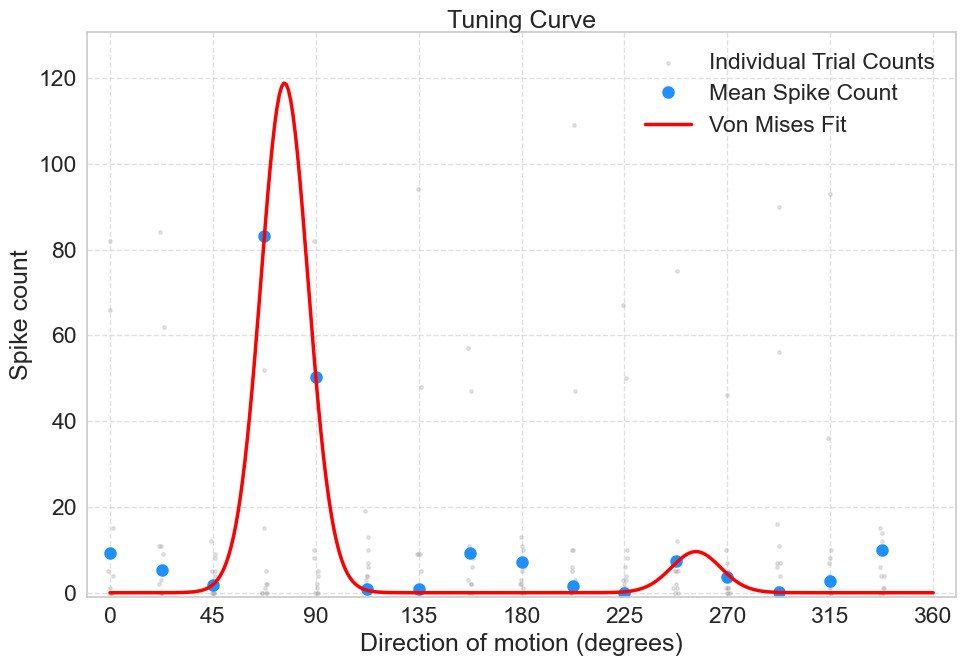

Neuron 37: dirs_sorted.shape = (176,), counts_sorted.shape = (176,)


In [56]:
neurons_to_plot = [28, 29, 37]
for neuron in neurons_to_plot:
    dirs_sorted, counts_sorted = get_data(spikes, neuron)
    result = tuningCurve(counts_sorted, dirs_sorted, show=True)
    if len(result) == 4:
        print(f"Neuron {neuron}: dirs_sorted.shape = {dirs_sorted.shape}, counts_sorted.shape = {counts_sorted.shape}")
    else:
        print(f"Neuron {neuron}: No result from tuningCurve()")

In [ ]:
# ----------------------------------------------------------
# plot the average number of spikes per direction, the spike 
# counts from individual trials as well as your optimal fit 
# for different neurons (0.5 pts)
# ----------------------------------------------------------


## Task 4: Permutation test for direction tuning

Implement a permutation test to quantitatively assess whether a neuron is direction/orientation selective. To do so, project the vector of average spike counts, $m_k=\frac{1}{N}\sum_j x_{jk}$ on a complex exponential with two cycles, $v_k = \exp(\psi i \theta_k)$, where $\theta_k$ is the $k$-th direction of motion in radians and $\psi \in 1,2$ is the fourier component to test (1: direction, 2: orientation). Denote the projection by $q=m^Tv$. The magnitude $|q|$ tells you how much power there is in the $\psi$-th fourier component. 

Estimate the distribution of |q| under the null hypothesis that the neuron fires randomly across directions by running 1000 iterations where you repeat the same calculation as above but on a random permutation of the trials (that is, randomly shuffle the entries in the spike count matrix x). The fraction of iterations for which you obtain a value more extreme than what you observed in the data is your p-value. Implement this procedure in the function ```testTuning()```. 

Illustrate the test procedure for one of the cells from above. Plot the sampling distribution of |q| and indicate the value observed in the real data in your plot. 

How many cells are tuned at p < 0.01?

*Grading: 3 pts*


In [ ]:
def testTuning(
    counts: np.ndarray,
    dirs: np.ndarray,
    psi: int = 1,
    niters: int = 1000,
    show: bool = False,
    random_seed: int = 2046,
) -> Tuple[float, float, np.ndarray]:
    """Plot the data if show is True, otherwise just return the fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    psi: int
        fourier component to test (1 = direction, 2 = orientation)

    niters: int
        Number of iterations / permutation

    show: bool
        Plot or not.

    random_seed: int
        Random seed for reproducibility.

    Returns
    -------
    p: float
        p-value
    q: float
        magnitude of second Fourier component

    qdistr: np.array
        sampling distribution of |q| under the null hypothesis

    """
    
    # -------------------------------
    # calculate m, nu and q (0.5 pts)
    # -------------------------------

    # -------------------------------------------------------------------------
    # Estimate the distribution of q under the H0 and obtain the p value (1 pt)
    # -------------------------------------------------------------------------
    # ensure reproducibility using a random number generator
    # hint: access random functions of this generator
    rng = np.random.default_rng(random_seed)


    if show:
        # add plotting code here
        pass

In [16]:
def compute_null_distribution(
    counts: np.ndarray,
    dirs: np.ndarray,
    v_k: np.ndarray,
    niters: int,
   rng: np.random.Generator) -> np.ndarray:
    """Compute the null distribution of |q| under the null hypothesis.

    Parameters
    ----------
    counts: np.ndarray
        The spike counts for each trial.

    dirs: np.ndarray
        The stimulus directions for each trial.

    v_k: np.ndarray
        The complex exponential vector for the specified psi.

    niters: int
        Number of iterations for the permutation test.

    rng: np.random.Generator
        Random number generator for reproducibility. 
    Returns
    -------
    q_distribution_null: np.ndarray
        The computed null distribution of |q|.

    """
    # Initialize an array to store the |q| values from each permutation
    q_distribution_null = np.zeros(niters)
    logger.info(f"Starting permutation test with {niters} iterations...")
    
    # Loop over the number of iterations
    for i in range(niters):
        # 1. Permute the data: Shuffle the spike counts randomly across all trials.
        shuffled_trial_counts = rng.permutation(counts)
        
        # 2. Recalculate m_k (average spike count per direction) for this permuted dataset.
        permuted_spike_matrix = compute_spike_count_matrix(shuffled_trial_counts, dirs)
        m_k_permuted = np.mean(permuted_spike_matrix, axis=0)
        
        # 3. Recalculate |q| using the permuted m_k_permuted and the *original* v_k.
        # v_k does not change because it depends on the stimulus directions and psi,
        # which are fixed.
        q_complex_permuted = np.dot(m_k_permuted, v_k)
        q_magnitude_permuted = np.abs(q_complex_permuted)
        
        # 4. Store the magnitude from this permutation.
        q_distribution_null[i] = q_magnitude_permuted
        
        if (i + 1) % (niters // 10) == 0: # Log progress every 10%
            logger.debug(f"Permutation iteration {i+1}/{niters} completed.")

    logger.info("Permutation test finished.")
    
    return q_distribution_null


In [42]:
def plot_null_distribution(q_distribution_null: np.ndarray, 
                           q_observed_magnitude: float, 
                           niters: int, 
                           title: str = "Null Distribution of |q|"):
    """Plot the null distribution of |q| and the observed |q|.

    Parameters
    ----------
    q_distribution_null: np.ndarray
        The computed null distribution of |q|.

    q_observed_magnitude: float
        The observed magnitude of |q| from the original data.

    niters: int
        Number of iterations for the permutation test.
    """
    plt.figure(figsize=(8, 6))
    
    # Plot the histogram of the null distribution
    plt.hist(q_distribution_null, bins=50, density=True, alpha=0.7, color='skyblue', 
             label=f'Null Distribution of |q|\n({niters} permutations)')
    
    # Add a vertical line for the observed |q|
    plt.axvline(x=q_observed_magnitude, color='red', linestyle='--', linewidth=2,
                label=f'Observed |q| = {q_observed_magnitude:.4f}')
    
    plt.title(title)
    plt.xlabel('|q|')
    plt.ylabel('Density')
    plt.legend()
    plt.grid()
    plt.show()

In [43]:
def testTuning(
    counts: np.ndarray,
    dirs: np.ndarray,
    psi: int = 1,
    niters: int = 1000,
    show: bool = False,
    random_seed: int = 2046,
) -> Tuple[float, float, np.ndarray]:
    """Plot the data if show is True, otherwise just return the fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    psi: int
        fourier component to test (1 = direction, 2 = orientation)

    niters: int
        Number of iterations / permutation

    show: bool
        Plot or not.

    random_seed: int
        Random seed for reproducibility.

    Returns
    -------
    p: float
        p-value
    q: float
        magnitude of second Fourier component

    qdistr: np.array
        sampling distribution of |q| under the null hypothesis

    """
    # -------------------------------
    # Calculate m, nu and q (0.5 pts)
    # -------------------------------
    # m - This is the vector of average spike counts for each unique stimulus direction.
    spike_count_matrix = compute_spike_count_matrix(counts, dirs) # 'counts' and 'dirs' are 1D arrays of all trials
    m_k = np.mean(spike_count_matrix, axis=0)  # Shape: (nUniqueDirs,)

    # Get unique directions and convert to radians for v_k
    unique_stim_directions_deg = np.unique(dirs) # These are the directions corresponding to columns of spike_count_matrix
    theta_k_rad = np.deg2rad(unique_stim_directions_deg) # Shape: (nUniqueDirs,)
        
    # v_k - This is the complex exponential vector for the specified psi.
    # It should be based on the unique radian directions theta_k_rad.
    v_k = np.exp(1j * psi * theta_k_rad)  # Corrected: Shape: (nUniqueDirs,)
        
    # q - This is the projection of m_k onto v_k.
    q_complex_observed = np.dot(m_k, v_k)

    # Magnitude of the projection for the observed data.
    # This is the 'q' to be returned and tested against null distribution.
    q_observed_magnitude = np.abs(q_complex_observed) 

    logger.debug(f"Observed q magnitude: {q_observed_magnitude}")
    logger.debug(f"Observed q complex: {q_complex_observed}")
    logger.debug(f"Observed m_k: {m_k}")
    logger.debug(f"Observed v_k: {v_k}")
    
    # -------------------------------------------------------------------------
    # Estimate the distribution of q under the H0 and obtain the p value (1 pt)
    # -------------------------------------------------------------------------
    # Ensure reproducibility using a random number generator
    # Hint: Access random functions of this generator
    rng = np.random.default_rng(random_seed)

    # 1-4. Compute the null distribution of |q| under the null hypothesis
    #    by running niters iterations where you repeat the same calculation as above
    #    but on a random permutation of the trials (that is, randomly shuffle the entries in the spike count matrix x).
    #    This is done in the compute_null_distribution function.
    #    The q_distribution_null is the array of |q| values from the null distribution.
    #    The function compute_null_distribution is defined above.
    #    It takes the counts, dirs, v_k, niters, and rng as inputs.
    q_distribution_null = compute_null_distribution(counts=counts, dirs=dirs,
                                                    v_k=v_k, niters=niters, rng=rng)
    
    # 5. Calculate the p-value.
    #    This is the proportion of permuted |q| values that are as extreme as,
    #    or more extreme than, the |q| observed from the original data.
    # We use smoothing to avoid p-values of 0 or 1.
    p_value = (np.sum(q_distribution_null >= q_observed_magnitude) + 1) / (niters + 1)
    # p_value = np.sum(q_distribution_null >= q_observed_magnitude) / niters

    # For a slightly more robust p-value, especially if niters is not huge or q_observed_magnitude is very extreme:
    # p_value_corrected = (np.sum(q_distribution_null >= q_observed_magnitude) + 1) / (niters + 1)
    # You can choose which one to use; the simpler one is fine for this lab typically.
    logger.info(f"Observed |q|: {q_observed_magnitude:.4f}, Calculated p-value: {p_value:.35f}")

    if show:
        title = f"Null Distribution Neuron:{neuron} $\Psi$ : {psi}  P Value: {p_value:.05f}"
        plot_null_distribution(q_distribution_null, q_observed_magnitude, niters, title=title)
    # The array q_distribution_null is the 'qdistr' to be returned.
    qdistr = q_distribution_null
    return p_value, q_observed_magnitude, qdistr


In [36]:
def test_neuron_tuning(all_neuron_ids, spikes, niters=1000):
    """Test the tuning of a neuron for direction and orientation."""
    tuning_results = []

    for i, neuron_id in enumerate(all_neuron_ids):
        logger.info(f"Processing neuron {i+1}/{len(all_neuron_ids)}: ID {neuron_id}...")

        # Get data for the current neuron
        dirs_sorted, counts_sorted = get_data(spikes, neuron_id)

        # It's possible some neurons might have no spikes in the defined periods.
        # get_data should produce empty or all-zero counts_sorted in such cases.
        # testTuning should ideally handle this (e.g., result in a non-significant p-value).
        # For instance, if all counts are 0, m_k will be 0, q_observed_magnitude will be 0,
        # and p_value will likely be 1.0, which is correct (not selective).

        # Test for direction tuning (psi=1)
        p_direction, q_direction, _ = testTuning(
            counts_sorted, 
            dirs_sorted, 
            psi=1, 
            niters=niters, 
            show=False # No plots for batch processing
        )

        # Test for orientation tuning (psi=2)
        p_orientation, q_orientation, _ = testTuning(
            counts_sorted, 
            dirs_sorted, 
            psi=2, 
            niters=niters, 
            show=False 
        )

        tuning_results.append({
            'neuron_id': neuron_id,
            'p_direction': p_direction,
            'q_direction': q_direction,
            'p_orientation': p_orientation,
            'q_orientation': q_orientation
        })
        
    return pd.DataFrame(tuning_results)

In [29]:
def filter_tuning_results(tuning_results_df, alpha_threshold=0.01):
    """Filter the tuning results based on the significance level."""
    logging.debug(f"\n--- Tuning Selectivity Results (p < {alpha_threshold}) ---")

    direction_selective_neurons = tuning_results_df[tuning_results_df['p_direction'] < alpha_threshold]
    orientation_selective_neurons = tuning_results_df[tuning_results_df['p_orientation'] < alpha_threshold]

    logging.debug(f"\nDirection Selective Neurons (psi=1, p < {alpha_threshold}):")
    if not direction_selective_neurons.empty:
        logging.debug(direction_selective_neurons[['neuron_id', 'p_direction', 'q_direction']])
    else:
        logging.debug("No neurons found to be significantly direction selective at this threshold.")

    logging.debug(f"\nOrientation Selective Neurons (psi=2, p < {alpha_threshold}):")
    if not orientation_selective_neurons.empty:
        logging.debug(orientation_selective_neurons[['neuron_id', 'p_orientation', 'q_orientation']])
    else:
        logging.debug("No neurons found to be significantly orientation selective at this threshold.")

    # You might also be interested in neurons that are BOTH or EXCLUSIVELY one type
    both_selective = tuning_results_df[
        (tuning_results_df['p_direction'] < alpha_threshold) & 
        (tuning_results_df['p_orientation'] < alpha_threshold)
    ]
    logging.debug(f"\nNeurons Selective for BOTH Direction and Orientation (p < {alpha_threshold}):")
    if not both_selective.empty:
        logging.debug(both_selective[['neuron_id', 'p_direction', 'p_orientation']])
    else:
        logging.debug("No neurons found to be significantly selective for both at this threshold.")

    # Example: Strictly direction selective (significant for direction, not for orientation)
    strictly_direction_selective = tuning_results_df[
        (tuning_results_df['p_direction'] < alpha_threshold) & 
        (tuning_results_df['p_orientation'] >= alpha_threshold)
    ]
    logging.debug(f"\nNeurons Strictly Direction Selective (p_dir < {alpha_threshold}, p_ori >= {alpha_threshold}):")
    if not strictly_direction_selective.empty:
        logging.debug(strictly_direction_selective[['neuron_id', 'p_direction', 'p_orientation']])
    else:
        logging.debug("No neurons found to be strictly direction selective at this threshold.")
    return (direction_selective_neurons, 
            orientation_selective_neurons, 
            both_selective, 
            strictly_direction_selective)

Show null distribution for the example cell:

2025-05-18 11:39:54,383 - INFO - Fitting tuning curve...
2025-05-18 11:39:54,383 - INFO - Counts: (176,)
2025-05-18 11:39:54,384 - INFO - Dirs: (176,)
2025-05-18 11:39:54,386 - INFO - Spike count matrix shape: (11, 16)
2025-05-18 11:39:54,387 - INFO - Spike count matrix: [[ 0. 16. 14.  0.  0.  0.  0.  0.  0. 32. 31.  0.  0.  0.  0.  0.]
 [ 0. 10. 13.  0.  0.  0.  0.  0.  0. 44. 19.  0.  0.  0.  0.  0.]
 [ 0. 20. 14.  0.  0.  0.  0.  0.  0. 41. 42.  0.  0.  0.  0.  0.]
 [ 0. 10. 16.  0.  0.  0.  0.  0.  0. 54. 32.  0.  0.  0.  0.  0.]
 [ 0. 24. 16.  0.  0.  0.  0.  0.  0. 43. 55.  0.  0.  0.  0.  0.]
 [ 0.  9. 13.  0.  0.  0.  0.  0.  0. 52. 41.  0.  0.  0.  0.  0.]
 [ 0. 19. 15.  0.  0.  0.  0.  0.  0. 44. 30.  3.  0.  0.  0.  0.]
 [ 0. 15.  3.  0.  0.  0.  0.  0.  0. 48. 47.  1.  0.  0.  0.  0.]
 [ 0. 25. 24.  0.  0.  0.  0.  0.  3. 45. 26.  1.  0.  0.  0.  0.]
 [ 0. 11. 29.  0.  1.  0.  0.  0.  1. 37. 40.  2.  0.  0.  0.  0.]
 [ 0. 14. 17.  0.  0.  0.  0.  0.  0. 48. 39.  2.  0.  0. 

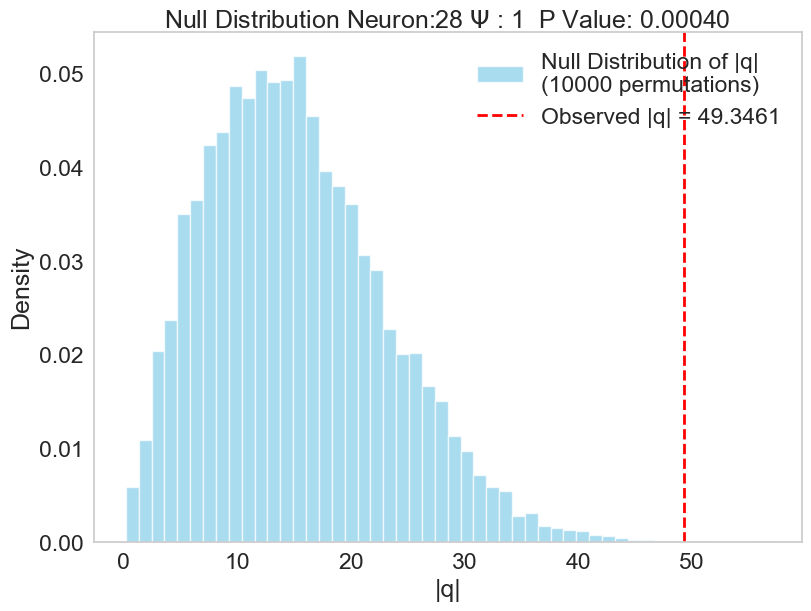

2025-05-18 11:39:58,272 - INFO - Neuron:28 psi == 1 ->  p-value: 0.00039996000399960006, q_observed_magnitude: 49.34605505462993
2025-05-18 11:39:58,274 - INFO - Starting permutation test with 10000 iterations...
2025-05-18 11:40:01,469 - INFO - Permutation test finished.
2025-05-18 11:40:01,469 - INFO - Observed |q|: 104.2576, Calculated p-value: 0.00009999000099990001542895473596317


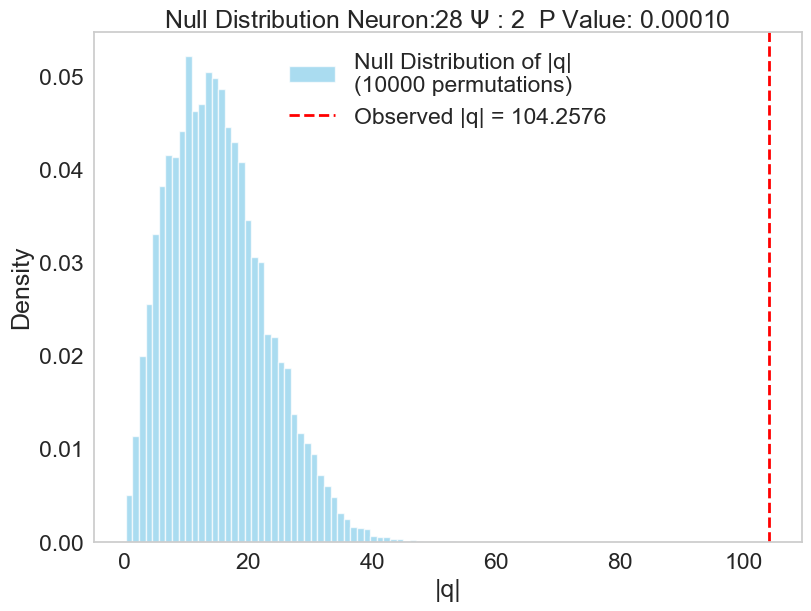

2025-05-18 11:40:02,017 - INFO - Neuron:28 psi == 2 ->  p-value: 9.999000099990002e-05, q_observed_magnitude: 104.25762657685993
2025-05-18 11:40:02,026 - INFO - Fitting tuning curve...
2025-05-18 11:40:02,027 - INFO - Counts: (176,)
2025-05-18 11:40:02,028 - INFO - Dirs: (176,)
2025-05-18 11:40:02,029 - INFO - Spike count matrix shape: (11, 16)
2025-05-18 11:40:02,031 - INFO - Spike count matrix: [[ 5.  2.  4. 13.  2.  0.  0.  9.  0.  1. 24.  0.  2.  0.  1.  1.]
 [ 0.  0. 19. 20.  8.  3.  0.  3.  2.  0.  9.  8.  4.  0.  0.  2.]
 [ 0.  0.  9. 19. 13.  1.  0.  4.  0.  0.  6.  0. 15.  0.  0.  6.]
 [ 0.  0.  1. 16.  3.  1.  5.  2.  0.  1.  7. 11.  7.  0.  0.  6.]
 [ 0.  0. 28. 12.  3.  1. 10.  1.  0.  0.  1.  7.  6.  0.  0.  1.]
 [ 0.  0. 14. 25.  7.  4.  1.  8.  0.  0.  1.  4.  5.  0.  0.  0.]
 [ 0.  0. 15. 12.  9.  2.  1.  3.  3.  0. 11.  3.  7.  0.  0.  2.]
 [ 6.  4. 19. 27.  5.  2.  4.  5.  4.  0. 16.  6.  6.  1.  0.  0.]
 [ 3.  2. 14. 23.  5.  2.  3.  2.  4.  0. 16.  4.  5.  1.  0.  

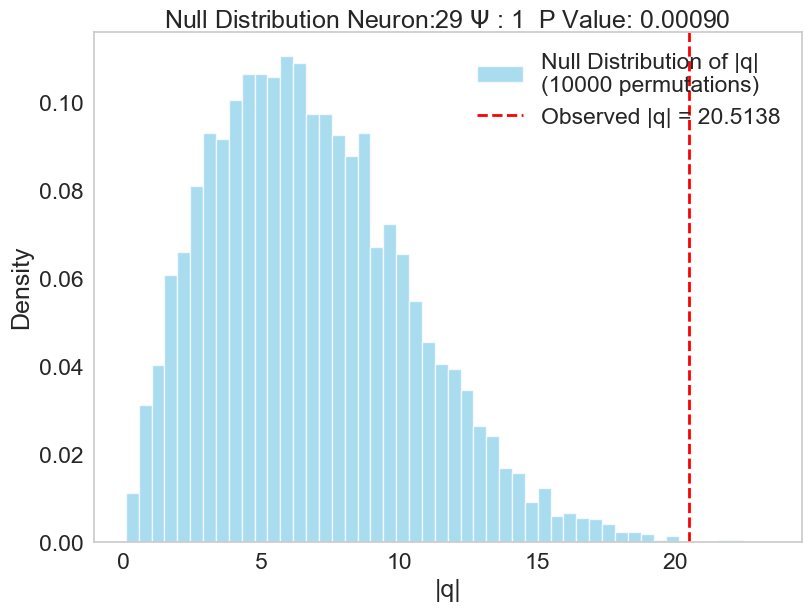

2025-05-18 11:40:05,544 - INFO - Neuron:29 psi == 1 ->  p-value: 0.0008999100089991, q_observed_magnitude: 20.51379441068113
2025-05-18 11:40:05,546 - INFO - Starting permutation test with 10000 iterations...
2025-05-18 11:40:08,983 - INFO - Permutation test finished.
2025-05-18 11:40:08,984 - INFO - Observed |q|: 40.4493, Calculated p-value: 0.00009999000099990001542895473596317


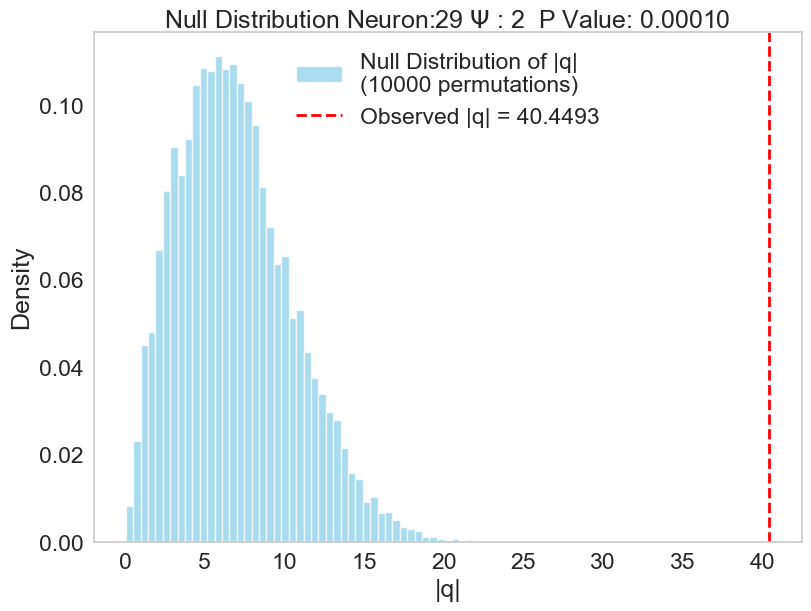

2025-05-18 11:40:09,638 - INFO - Neuron:29 psi == 2 ->  p-value: 9.999000099990002e-05, q_observed_magnitude: 40.44931965569163


In [44]:
# ---------------------------------------------------------
# Plot null distributions for example cells 28 & 29. (1 pt)
# ---------------------------------------------------------
neurons_to_plot = [28, 29]
for neuron in neurons_to_plot:
    dirs_sorted, counts_sorted = get_data(spikes, neuron)
    result = tuningCurve(counts_sorted, dirs_sorted, show=True)
    for psi in [1, 2]:
        p_value, q_observed_magnitude, qdistr = testTuning(counts_sorted, dirs_sorted, 
                                                           psi=psi, show=True, niters=10000)
        logger.info(f"Neuron:{neuron} psi == {psi} ->  p-value: {p_value}, q_observed_magnitude: {q_observed_magnitude}")


Test all cells for orientation and direction tuning

In [45]:
# --------------------------------------------------
# Test all cells for orientation / direction tuning. 
# Which ones are selective? (0.5 pts)
# --------------------------------------------------
#%%
neuron_tuning_results_df = test_neuron_tuning(np.unique(spikes['Neuron']), spikes, niters=1000)
#%% Filter the results based on the significance level
direction_selective_neurons, orientation_selective_neurons, both_selective, strictly_direction_selective = \
    filter_tuning_results(neuron_tuning_results_df, alpha_threshold=0.01)


2025-05-18 11:41:48,560 - INFO - Processing neuron 1/41: ID 1...
2025-05-18 11:41:48,574 - INFO - Starting permutation test with 1000 iterations...
2025-05-18 11:41:48,911 - INFO - Permutation test finished.
2025-05-18 11:41:48,911 - INFO - Observed |q|: 5.6842, Calculated p-value: 0.87812187812187814106579253348172642
2025-05-18 11:41:48,914 - INFO - Starting permutation test with 1000 iterations...
2025-05-18 11:41:49,262 - INFO - Permutation test finished.
2025-05-18 11:41:49,263 - INFO - Observed |q|: 8.9238, Calculated p-value: 0.69230769230769229061195346730528399
2025-05-18 11:41:49,263 - INFO - Processing neuron 2/41: ID 2...
2025-05-18 11:41:49,275 - INFO - Starting permutation test with 1000 iterations...
2025-05-18 11:41:49,593 - INFO - Permutation test finished.
2025-05-18 11:41:49,594 - INFO - Observed |q|: 13.1883, Calculated p-value: 0.47652347652347654127780174349027220
2025-05-18 11:41:49,597 - INFO - Starting permutation test with 1000 iterations...
2025-05-18 11:41:4

In [50]:
num_direction_tuned = len(direction_selective_neurons)
num_orientation_tuned = len(orientation_selective_neurons)
num_both_tuned = len(both_selective) # 'both_selective' from your filter_tuning_results

total_unique_tuned_cells = num_direction_tuned + num_orientation_tuned - num_both_tuned

print(f"Total number of unique neurons showing any tuning (direction or orientation, p < 0.01): {total_unique_tuned_cells}")

Total number of unique neurons showing any tuning (direction or orientation, p < 0.01): 34


Number of direction tuned neurons:

In [46]:
print(f"Number of direction selective neurons: {len(direction_selective_neurons)}")

Number of direction selective neurons: 12


Number of orientation tuned neurons:

In [47]:
print(f"Number of orientation selective neurons: {len(orientation_selective_neurons)}")

Number of orientation selective neurons: 34


In [48]:
print(f"Number of neurons selective for both: {len(both_selective)}")
print(f"Number of strictly direction selective neurons: {len(strictly_direction_selective)}")

Number of neurons selective for both: 12
Number of strictly direction selective neurons: 0
